In [2]:

%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import Tensor
from torch.nn import Transformer

import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from Transformer.model import eeg2melTransformer
from torch.utils.data import DataLoader
from dataset import meleeg_dataset
import torch
import time
import os


In [3]:

class eeg2melTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_feature_size: int,
                 tgt_feature_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(eeg2melTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.src_fc = nn.Linear(src_feature_size, emb_size)
        self.tgt_fc = nn.Linear(tgt_feature_size, emb_size)
        self.generator = nn.Linear(emb_size, tgt_feature_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_fc(src))
        tgt_emb = self.positional_encoding(self.tgt_fc(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_fc(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_fc(tgt)), memory, tgt_mask)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)




In [6]:
def save_checkpoint(epoch, model, optimizer, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_checkpoint(path, model, optimizer):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        return epoch
    else:
        return None


In [7]:
from dataset import meleeg_dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = meleeg_dataset()
val_dataset = meleeg_dataset(file_types=["val"])
test_dataset = meleeg_dataset(file_types=["test"])
# DataLoaders
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Model
model = eeg2melTransformer(
    num_encoder_layers=2,
    num_decoder_layers=2,
    emb_size=128,
    nhead=8,
    src_feature_size=64,
    tgt_feature_size=10
)

model =model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

checkpoint_path = "model_checkpoint.pth"

# Attempt to load the checkpoint if it exists
loaded_epoch = load_checkpoint(checkpoint_path, model, optimizer)

# If a checkpoint was loaded, use its epoch and hyperparameters
if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    # Update hyperparameters if needed
else:
    start_epoch = 0
max_batches =1

for epoch in range(num_epochs):
    start_time = time.time()

    # Training phase
    model.train()
    total_train_loss = 0
    for batch_idx, (eeg, mel) in enumerate(train_dataloader):
        optimizer.zero_grad()
        eeg = eeg.to(device)
        mel = mel.to(device)
        output = model(eeg, mel, None, None, None, None, None)

        # Calculate loss and metric
        loss = pearson_loss(output, mel)
        metric = -pearson_loss(output, mel)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            metric = -pearson_loss(output, mel)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Training Loss: {loss.item()}, Metric:{metric.item()}")
            save_checkpoint(epoch, model, optimizer, hyperparameters, checkpoint_path)

        if batch_idx >= max_batches - 1:
            break
    num_batches_processed = min(max_batches, len(train_dataloader))
    avg_train_loss = total_train_loss / num_batches_processed


    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_metric = 0
    with torch.no_grad():
        for batch_idx,(eeg, mel) in enumerate(valid_dataloader):
            eeg = eeg.to(device)
            mel = mel.to(device)
            output = model(eeg, mel, None, None, None, None, None)

            output_flat = output.view(output.size(0), -1)
            mel_flat = mel.view(mel.size(0), -1)

                # Calculate loss and metric
            loss = pearson_loss(output, mel)
            metric = -pearson_loss(output, mel)
            total_val_loss += loss.item()
            total_val_metric += metric.item()

            if batch_idx >= max_batches - 1:
                break

    num_batches_processed_val = min(max_batches, len(valid_dataloader))
    avg_val_loss = total_val_loss / num_batches_processed_val
    avg_val_metric = total_val_metric / num_batches_processed_val

    print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {time.time() - start_time:.2f} seconds, "
          f"Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}, "
          f"Average Validation Metric: {avg_val_metric:.4f}")

print("Training completed.")






Epoch [1/1] completed in 0.91 seconds, Average Training Loss: 0.0056, Average Validation Loss: -0.3065, Average Validation Metric: 0.3065
Training completed.


In [8]:
e,m = train_dataset.__getitem__(0)

In [13]:
tri=model.encode(e[None,:,:],None)
tri.shape

torch.Size([1, 64, 128])

In [5]:



def pearson_non_mean(y_true, y_pred, axis=1):
    """
    Pearson correlation function implemented in PyTorch.
    """
    y_true_mean = y_true.mean(dim=axis, keepdim=True)
    y_pred_mean = y_pred.mean(dim=axis, keepdim=True)

    numerator = ((y_true - y_true_mean) * (y_pred - y_pred_mean)).sum(dim=axis, keepdim=True)
    std_true = ((y_true - y_true_mean) ** 2).sum(dim=axis, keepdim=True)
    std_pred = ((y_pred - y_pred_mean) ** 2).sum(dim=axis, keepdim=True)
    denominator = torch.sqrt(std_true * std_pred +1e-8)

    c = torch.zeros_like(numerator)
    # zero mask
    mask = (denominator != 0)

    # finally perform division
    c[mask] = numerator[mask] / denominator[mask]
    # PyTorch equivalent
    return  c



def pearson_correlation(y_true, y_pred, axis=1):
    """
    Pearson correlation function implemented in PyTorch.
    """
    y_true_mean = y_true.mean(dim=axis, keepdim=True)
    y_pred_mean = y_pred.mean(dim=axis, keepdim=True)

    numerator = ((y_true - y_true_mean) * (y_pred - y_pred_mean)).sum(dim=axis, keepdim=True)
    std_true = ((y_true - y_true_mean) ** 2).sum(dim=axis, keepdim=True)
    std_pred = ((y_pred - y_pred_mean) ** 2).sum(dim=axis, keepdim=True)
    denominator = torch.sqrt(std_true * std_pred + 1e-8)

    c = torch.zeros_like(numerator)
    # zero mask
    mask = (denominator != 0)

    # finally perform division
    c[mask] = numerator[mask] / denominator[mask]
    # PyTorch equivalent
    return  torch.mean(c)



def pearson_loss(y_true, y_pred, axis=1):
    """
    Pearson loss function in PyTorch, modified to return a scalar.
    """


    return -pearson_correlation(y_true, y_pred, axis=axis)


def pearson_metric(y_true, y_pred, axis=1):
    """
    Pearson metric function in PyTorch.
    """
    corr = pearson_correlation(y_true, y_pred, axis=axis)
    return corr.mean(dim=-1)



def evaluate_model(model, test_loaders, criterion, device):
    """Evaluate a model in PyTorch.

    Parameters
    ----------
    model: torch.nn.Module
        PyTorch model to evaluate.
    test_loaders: dict
        Mapping between a subject and a DataLoader containing the test set for the subject.
    criterion: loss function
        The loss function used for evaluation.
    device: torch.device
        Device to run the model on.

    Returns
    -------
    dict
        Mapping between a subject and the loss/evaluation score on the test set.
    """

# pearson acroos time
# mean across bands/features
# mean across samples per subjects
# mean across subjects 
    model.eval()
    evaluation = {}
    pmean=[]
    for subi,(subject, loader) in enumerate(test_loaders.items()):
        total_loss = 0
        all_labels = []
        all_predictions = []
        i=0
        with torch.no_grad():
            for eeg, mel_true in loader:
                eeg, mel_true = eeg.to(device), mel_true.to(device)
                outputs = model(eeg, mel_true, None, None, None, None, None)
                loss = criterion(outputs, mel_true)
                total_loss += loss.item()
                all_labels.append(mel_true)
                all_predictions.append(outputs)
                i+=1
                if i>2:
                    break
                
        # Concatenate all batches
        all_labels = torch.cat(all_labels, dim=0)
        all_predictions = torch.cat(all_predictions, dim=0)
        print(all_labels.shape)
        k=np.squeeze(pearson_non_mean(all_predictions,all_labels,axis=1))
        print(k.shape)
        # Calculate Pearson correlation
        band_correlations = k.mean(dim=0)
        pmean.append(k.mean())
        avg_loss = total_loss / len(loader)
        evaluation[subject] = {
            "loss": avg_loss,
            "pearson_correlation_per_band": band_correlations,
            "pMetric":pmean[-1]
        }

    return evaluation,pmean.mean()

In [30]:
e,m=test_dataset.__getitem__(0)
e[None,:,:].shape,m.shape

(torch.Size([1, 64, 64]), torch.Size([64, 10]))

In [35]:
model = eeg2melTransformer(
    num_encoder_layers=2,
    num_decoder_layers=2,
    emb_size=128,
    nhead=8,
    src_feature_size=64,
    tgt_feature_size=10
)

model =model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

checkpoint_path = "model_checkpoint.pth"

# Attempt to load the checkpoint if it exists
loaded_epoch = load_checkpoint(checkpoint_path, model, optimizer)

model.eval()
outputs = model(e[None,:,:])

TypeError: eeg2melTransformer.forward() missing 6 required positional arguments: 'trg', 'src_mask', 'tgt_mask', 'src_padding_mask', 'tgt_padding_mask', and 'memory_key_padding_mask'

In [1]:
model.encode(e)

NameError: name 'model' is not defined

In [34]:
outputs.shape

torch.Size([1, 64, 10])

In [ ]:
plt.plot(outputs[])

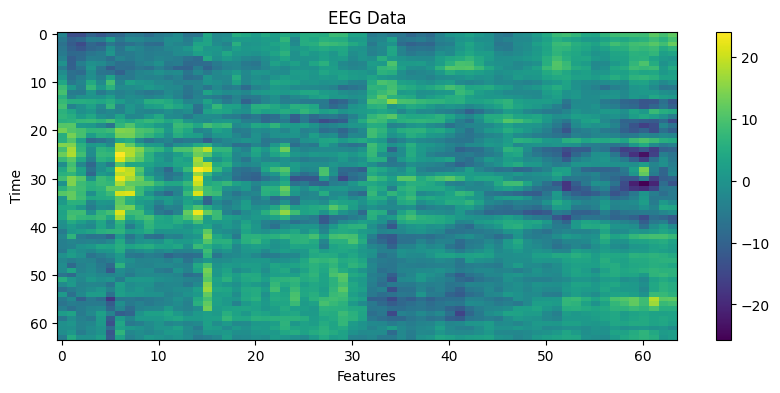

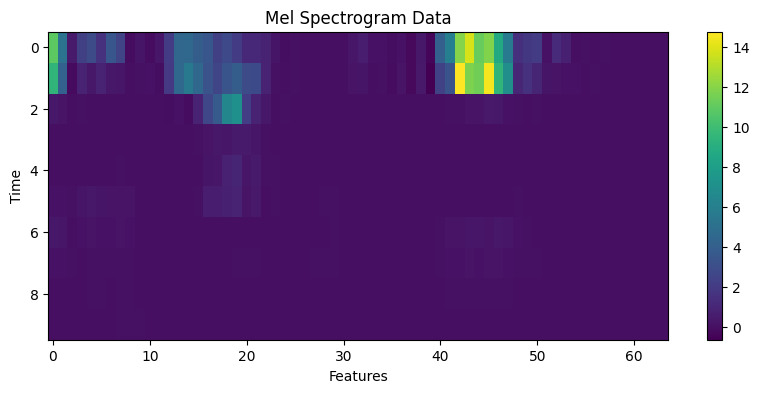

In [17]:
import matplotlib.pyplot as plt

def plot_tensor(tensor, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(tensor, aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Time')
    plt.show()

# Assuming e and m are your EEG and Mel tensors respectively
plot_tensor(e, 'EEG Data')
plot_tensor(m.T, 'Mel Spectrogram Data')


In [12]:
from dataset import meleeg_dataset
# # Test loop
# model.eval()
# total_test_loss = 0
# with torch.no_grad():
#     for eeg, mel in test_dataloader:
#         output = model(eeg, mel, None, None, None, None, None)
#         loss = pearson_loss(mel, output)
#         total_test_loss += loss.item()

# avg_test_loss = total_test_loss / len(test_dataloader)
# print(f"Average Test Loss: {avg_test_loss:.4f}")

test_files=[k  for k in os.listdir("/mnt/nvme/node02/pranav/AE24/data/split_data/") if "test" in k]
subjects = list(set([os.path.basename(x).split("_-_")[1] for x in test_files]))

test_dataset = meleeg_dataset(file_types=["test"])

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


datasets_test = {}
# Create a generator for each subject
for sub in subjects:

    test_sub_datset = meleeg_dataset(file_types=["test",sub])
    datasets_test[sub] = DataLoader(test_sub_datset, batch_size=batch_size, shuffle=False)
    print(sub,len(test_sub_datset))
#     break


# evaluation = evaluate_model(model, datasets_test,pearson_loss,device)



sub-004 730
sub-045 1198
sub-082 1238
sub-054 1199
sub-081 574
sub-046 1198
sub-024 1840
sub-077 670
sub-065 1420
sub-055 1199
sub-019 1840
sub-001 1840
sub-035 1511
sub-018 1840
sub-058 1357
sub-084 1238
sub-010 1840
sub-041 1363
sub-049 1199
sub-052 1199
sub-008 1840
sub-028 1446
sub-037 1363
sub-043 1198
sub-029 1446
sub-080 1238
sub-030 1446
sub-068 1420
sub-026 1840
sub-002 1902
sub-063 1420
sub-085 1238
sub-005 1668
sub-022 1826
sub-075 1218
sub-064 1420
sub-062 1357
sub-066 1420
sub-042 1363
sub-021 1826
sub-034 1511
sub-016 1840
sub-072 1218
sub-006 1648
sub-015 1840
sub-007 1840
sub-032 1511
sub-038 1363
sub-023 1826
sub-067 1420
sub-057 1357
sub-013 1840
sub-012 1840
sub-036 1511
sub-083 1238
sub-076 1218
sub-025 1668
sub-070 1420
sub-069 1420
sub-061 1357
sub-003 1840
sub-040 1363
sub-044 1198
sub-017 712
sub-014 1826
sub-047 1307
sub-048 1063
sub-071 1420
sub-009 1840
sub-050 669
sub-031 1446
sub-056 1199
sub-074 1218
sub-059 1357
sub-060 1172
sub-033 1511
sub-078 1218
sub-

In [57]:
len(evaluation['sub-008']['pMetric'])

384

In [59]:
casp=evaluation['sub-008']['pMetric']

In [73]:
casp.mean(dim=1).mean(dim=0)==casp.mean(dim=(0,1))

tensor(False)

In [ ]:
# We can save our results in a json encoded file
results_path = os.path.join(results_folder, results_filename)
with open(results_path, "w") as fp:
    json.dump(evaluation, fp)
logging.info(f"Results saved at {results_path}")